In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import HGate, UGate, QFT, RZGate
from numpy import pi, random
from qiskit.primitives import Sampler
import math

In [2]:
def adder(N, a):
    n = math.ceil(math.log2(N))
    U = QuantumCircuit(n)
    for i in range(n):
        U.append(RZGate(2 * pi * a/ 2 ** (i+1)), [i])
    return U.to_gate()

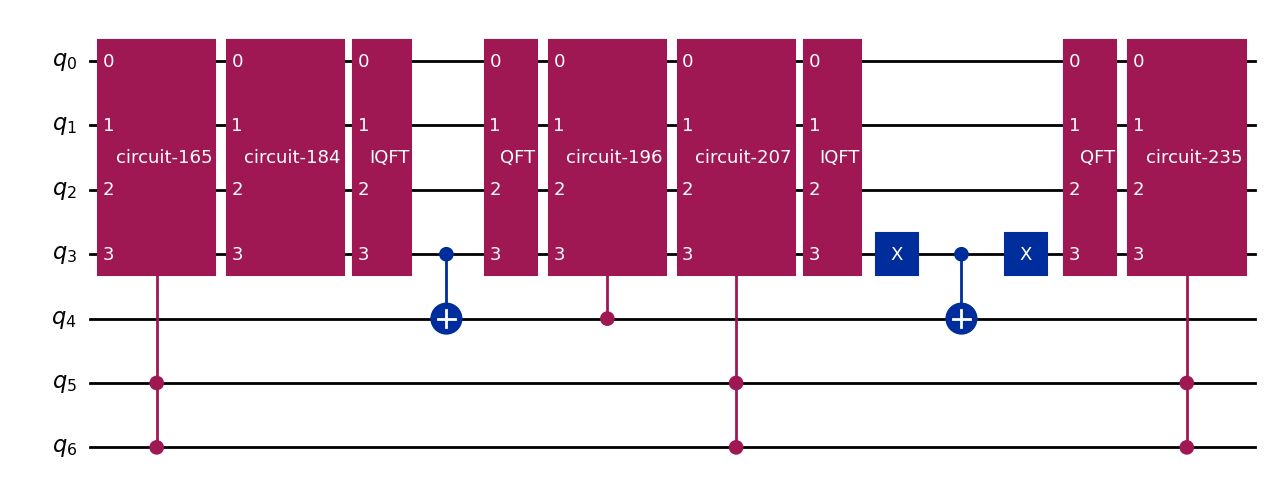

In [3]:
def c_moduler_adder(N, a):
    n = math.ceil(math.log2(N))
    U = QuantumCircuit(n + 3)
    U.append(adder(N, a).control(2), qargs=[n + 1, n + 2] + list(range(n)))
    U.append(adder(N, N), qargs=list(range(n)))
    U.append(QFT(n, inverse=True), qargs=list(range(n)))
    U.cx(control_qubit=n - 1, target_qubit=n)
    U.append(QFT(n), qargs=list(range(n)))
    U.append(adder(N, N).control(), qargs=[n] + list(range(n)))
    U.append(adder(N, a).control(2), qargs=[n + 1, n + 2] + list(range(n)))
    U.append(QFT(n, inverse=True), qargs=list(range(n)))
    U.x(n - 1)
    U.cx(n - 1, n)
    U.x(n - 1)
    U.append(QFT(n), list(range(n)))
    U.append(adder(N, a).control(2), [n + 1, n + 2] +list(range(n)))
    return U

c_moduler_adder(15, 7).draw("mpl")

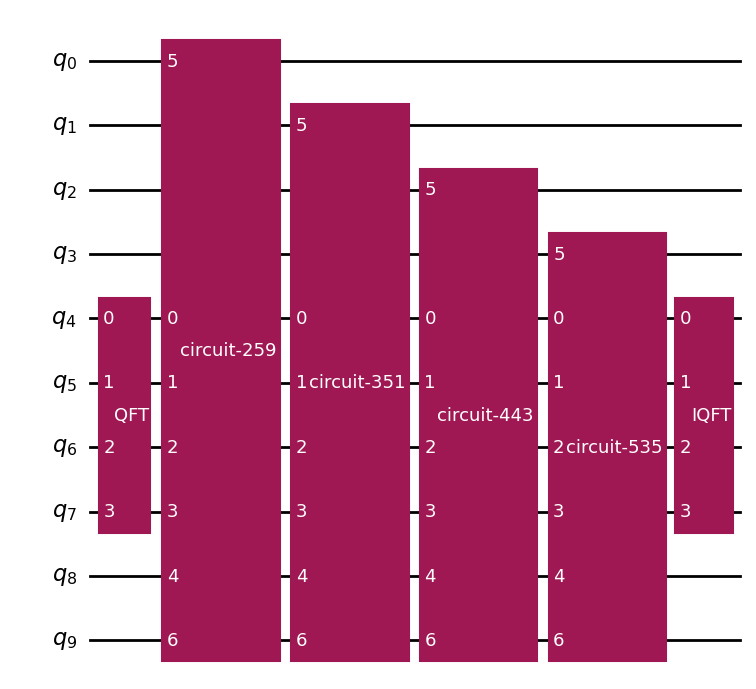

In [4]:
def c_multiply(N, a):
    n = math.ceil(math.log2(N))
    U = QuantumCircuit(n + n + 2)
    id_X = list(range(n))
    id_b = list(range(n, 2 * n))
    U.append(QFT(n), qargs=id_b)
    for i in range(n):
        U.append(c_moduler_adder(N, (2 ** i) * a), qargs=id_b + [2 * n, i, 2 * n + 1])
    U.append(QFT(n , inverse=True), qargs=id_b)
    return U

c_multiply(15, 7).draw("mpl")

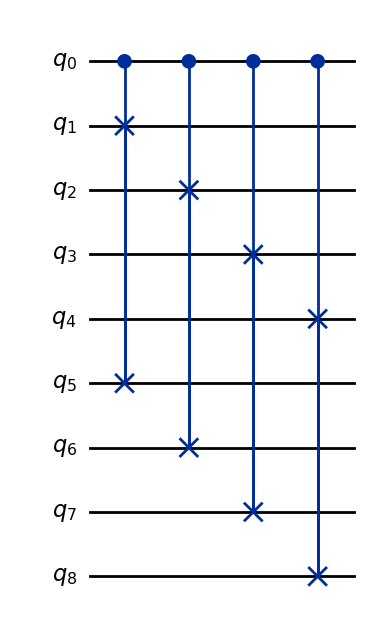

In [5]:
def c_swap(n):
    qc = QuantumCircuit(n * 2 + 1)
    id_c = [0]
    id_a = list(range(1, n + 1))
    id_b = list(range(n + 1, 2 * n + 1))
    for i in range(n):
        qc.cswap(id_c, id_a[i], id_b[i])
    return qc

c_swap(4).draw("mpl")

In [6]:
def qpow(a, b, p):
    ans = 1
    a = (a % p + p) % p
    while b:
        if b & 1:
            ans = (a * ans) % p
        a = (a * a) % p
        b >>= 1
    return ans

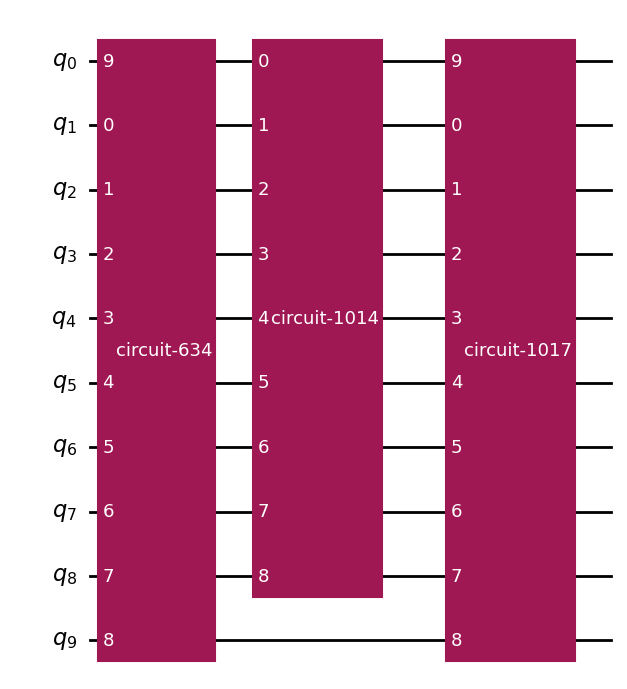

In [7]:
def general_U(N, a):
    n = math.ceil(math.log2(N))
    U = QuantumCircuit(2 * n + 2)
    id_X = list(range(1, n + 1))
    id_B = list(range(n + 1, 2 * n + 1))
    U.append(c_multiply(N, a), qargs=list(range(1, 2 * n + 2)) + [0])
    U.append(c_swap(n), qargs=[0] + id_X + id_B)
    a_inv = qpow(a, N - 2, N)
    U.append(c_multiply(N, a_inv), qargs=list(range(1, 2 * n + 2)) + [0])
    return U

general_U(15, 7).draw("mpl")

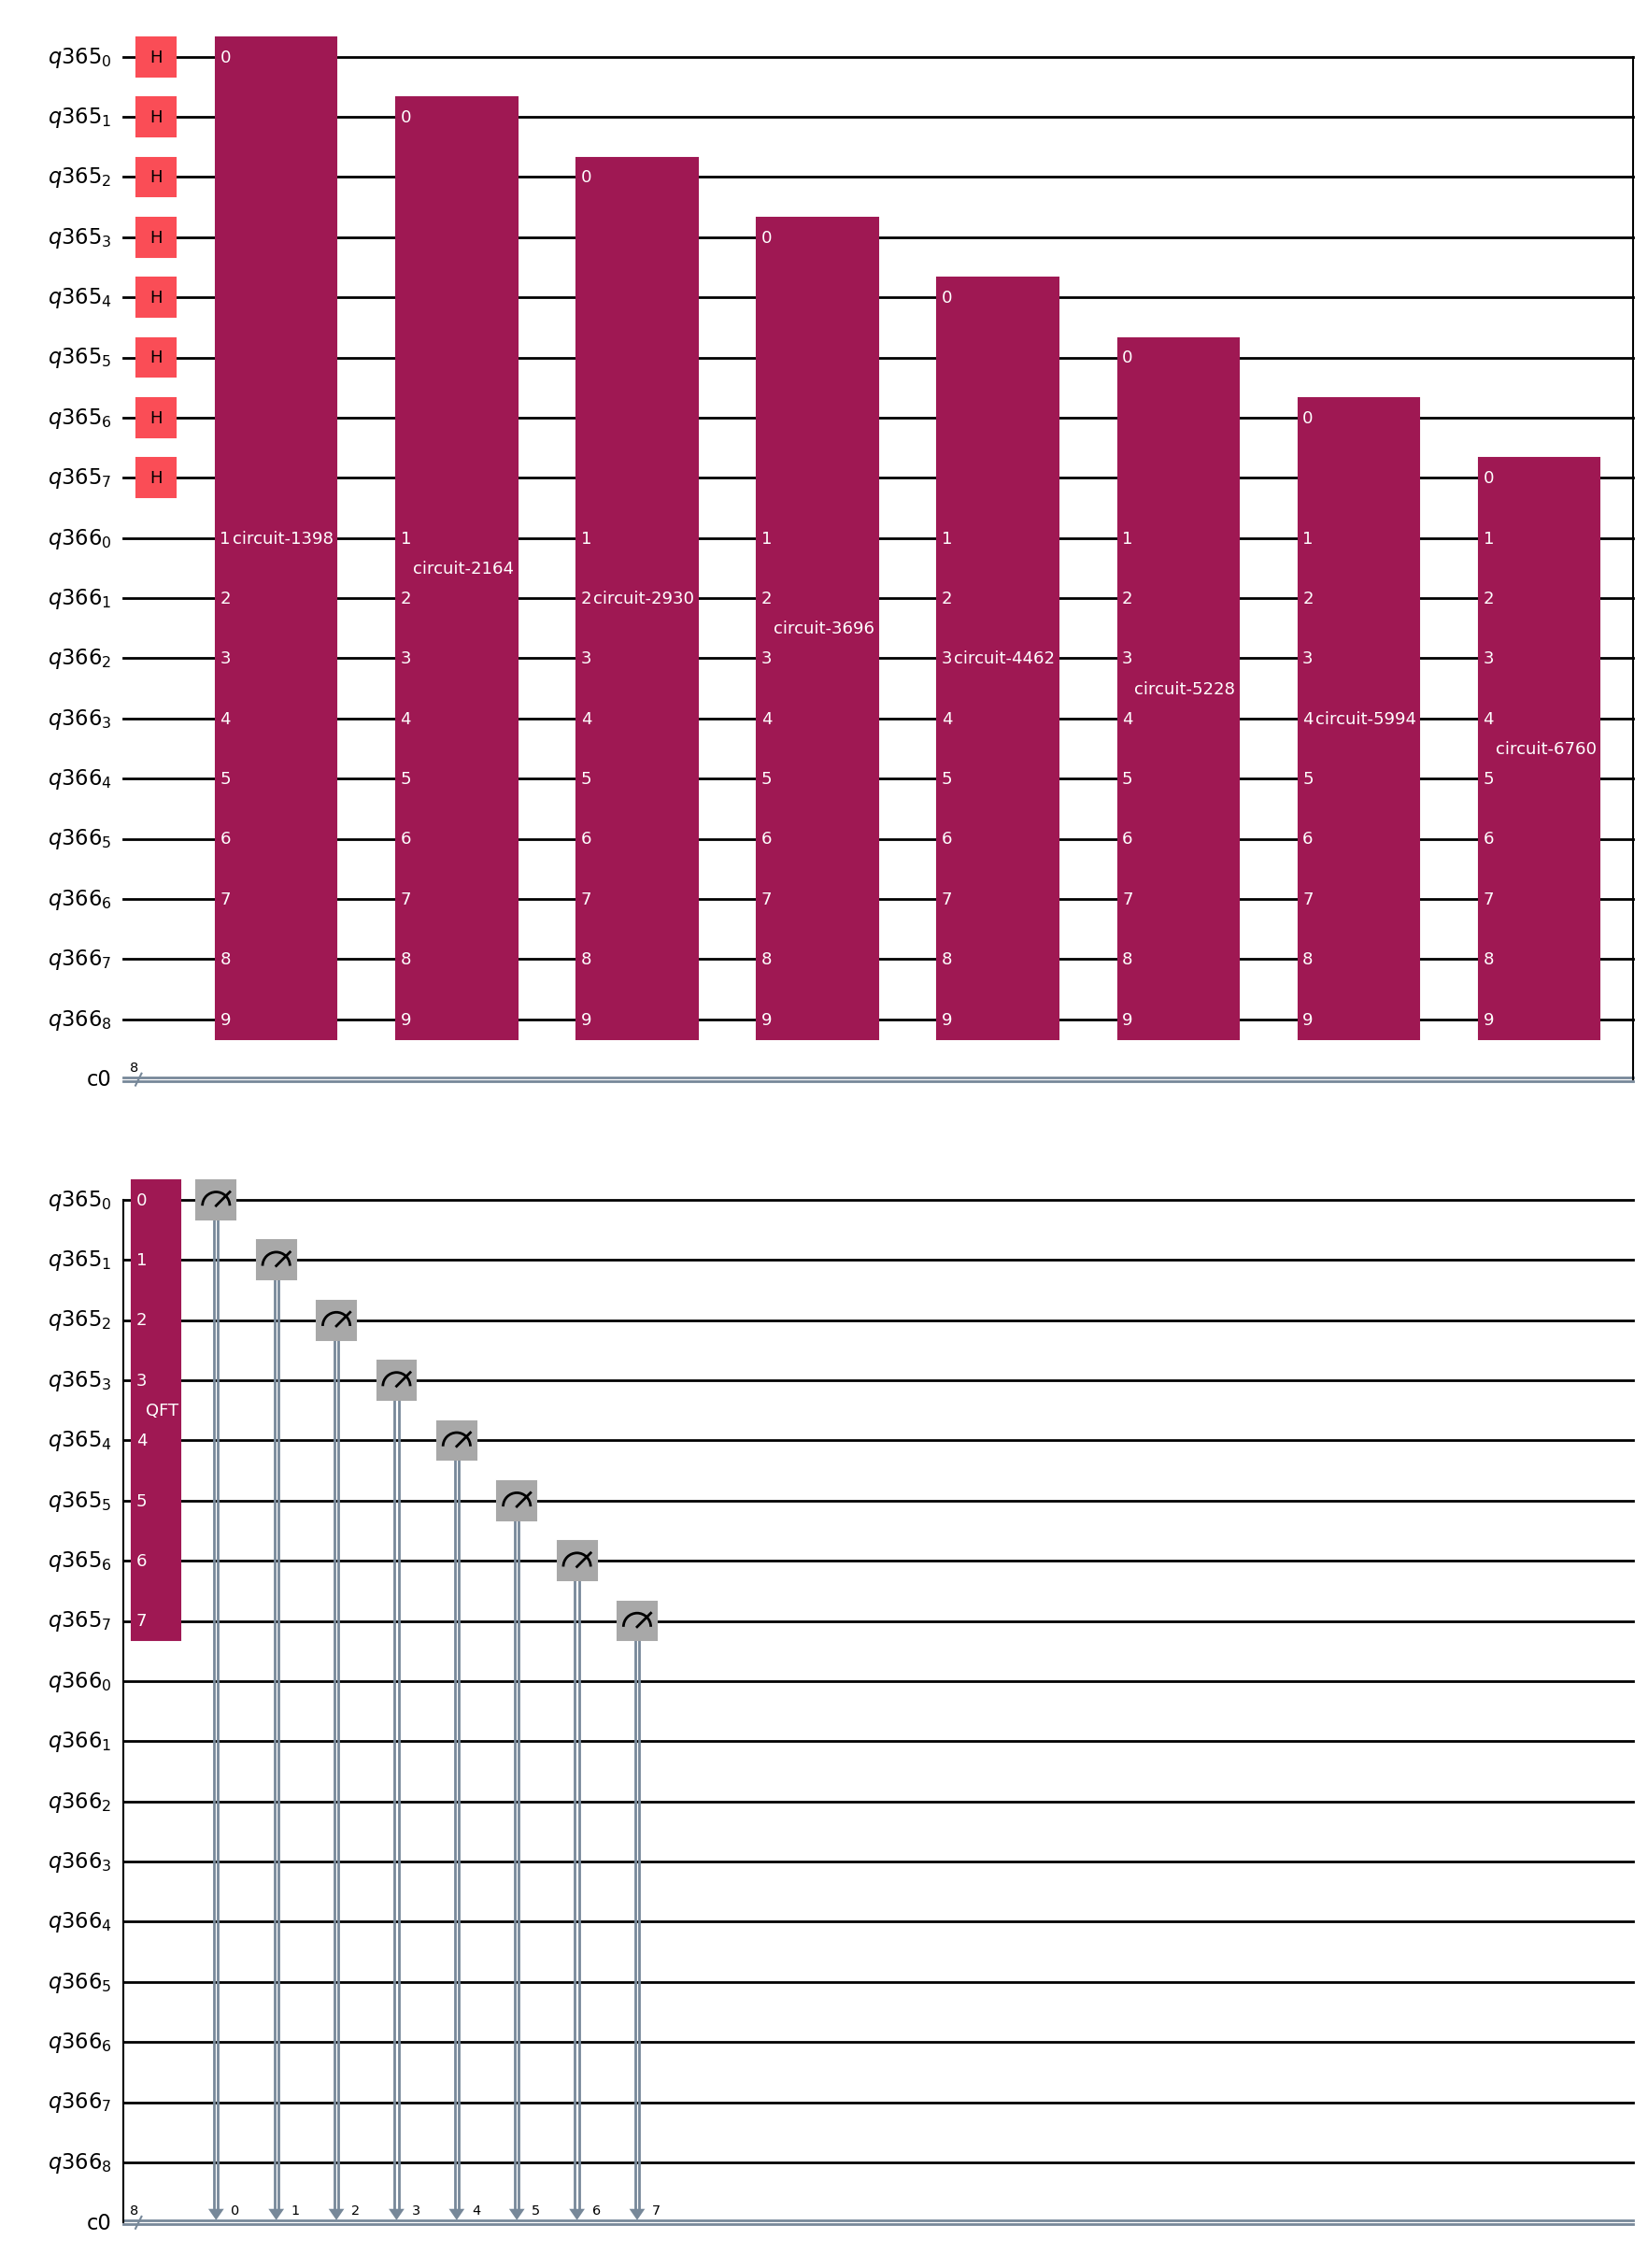

In [8]:
def shor(N, a):
    n = math.ceil(math.log(N, 2))
    control_reg = QuantumRegister(n * 2)
    target_reg = QuantumRegister(n * 2 + 1)
    output_reg = ClassicalRegister(n * 2)
    qc = QuantumCircuit(control_reg, target_reg, output_reg)
    for i in range(2 * n):
        qc.h(control_reg[i])
    for i in range(2 * n):
        qc.append(general_U(N, qpow(a, 2 ** i, N)), qargs=[control_reg[i]] + list(target_reg))
    qc.append(QFT(n * 2), qargs=list(control_reg))
    qc.measure(control_reg, output_reg)
    return qc

shor(15, 7).draw("mpl")

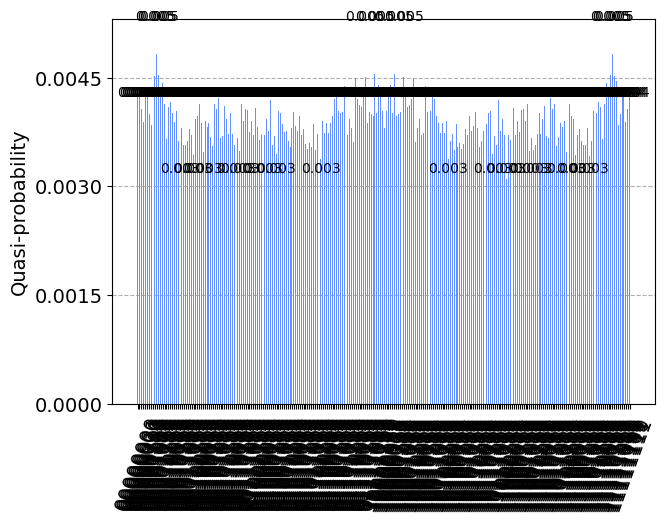

In [9]:
from qiskit.primitives import Sampler
results = Sampler().run(shor(15, 8), shot=1).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

In [11]:
from fractions import Fraction
from math import gcd

a = 5
N = 28
n = math.ceil(math.log2(N))

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = Sampler().run(shor(N, a), shots=1).result().quasi_dists[0].popitem()[0] / (2 ** (n * 2))
    print(f"Phase: {phase}")
    frac = Fraction(phase).limit_denominator(N)
    print(f"Fraction: {frac}")
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True


Attempt 1
Phase: 0.607421875
Fraction: 17/28
Non-trivial factor found: 4
